In [1]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as md
from pandas.plotting import register_matplotlib_converters

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

import pandas as pd
import numpy as np

In [20]:
trips_one_month = pd.read_csv('./RExtractor/output/JC-201904-citibike-tripdata.csv')
stations = pd.read_csv('./RExtractor/output/stationTable.csv')
ride = pd.read_csv('./RExtractor/ridershipdata/2019Q1.csv')

In [21]:
# Conversion d'un string en datetime
def convertStringToDatetime(hour, minute, second):
    date_time_str = str(hour)+':'+str(minute)+':'+str(round(second,3))
    date_time_obj = datetime.strptime(date_time_str, '%H:%M:%S.%f')
    date_time_obj = pd.to_datetime(date_time_obj)
    return date_time_obj

In [22]:
# Réalise le range d'intevalle pour un delta donné
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta



In [23]:
# Retourne
# La liste des dates où un vélo part d'une station
# La liste des dates où un vélo arrive à une station
# La liste des temps de trajets
def getDateData(dataset, mode="timestamp") : 
    dataset = dataset.reset_index(drop=True)
    s_day = dataset['start_day']
    s_month = dataset['start_month']
    s_year = dataset['start_year']
    s_hour = dataset['start_hour']
    s_minute = dataset['start_minute']
    s_second = dataset['start_second']

    e_day = dataset['end_day']
    e_month = dataset['end_month']
    e_year = dataset['end_year']
    e_hour = dataset['end_hour']
    e_minute = dataset['end_minute']
    e_second = dataset['end_second']
    
    data_s = []
    data_e = []
    data_diff = []
    for i in range(len(dataset)):
        start_date = convertStringToDatetime(s_hour[i], s_minute[i], s_second[i])
        end_date = convertStringToDatetime(e_hour[i], e_minute[i], e_second[i])
        delta = end_date-start_date
        if(mode =="timestamp"):
            data_s.append(start_date.timestamp())
            data_e.append(end_date.timestamp())
            data_diff.append(delta.total_seconds())
        else:
            data_s.append(start_date) 
            data_e.append(end_date)
            data_diff.append(delta)
    return data_s, data_e, data_diff

Test MSE: 162578.995


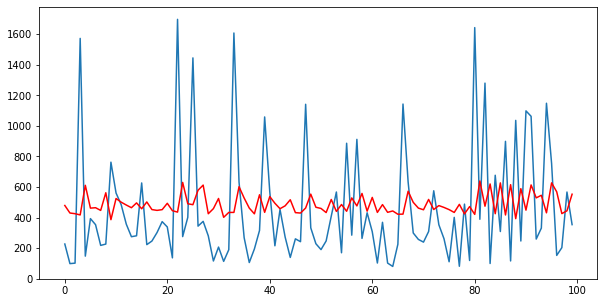

In [24]:
# Autoregression pour estimer le temps de trajet à partir d'une date de départ

def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat
data_s, data_e, data_diff = getDateData(trips_one_month)

train, test = data_diff[0:100], data_diff[100:200]
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [25]:
# TODO : faire couple start/end -> on a le départ et on prédit l'arrivée
# Todo : faire une prédiction du flux moyen sur la durée pour une station


# Liste d'intervalles de 30 min sur une journée
# (on filtre les trajet plus long)
dts30 = [dt.strftime('%H:%M:%S.%f') for dt in 
       datetime_range(datetime(2019,1,1, 0,0), datetime(2019,1,1, 23, 59), 
       timedelta(minutes=30))]

In [26]:
#On se concentre sur les trajet qui commencent ou finissent à une station donnée
dataset_station_s = trips_one_month[trips_one_month.start_station_id == 3183]

dataset_station_e = trips_one_month[trips_one_month.end_station_id == 3183]


In [27]:
#On extrait tout les mardis du mois (one day)
dataset_station_s_one_day = dataset_station_s[trips_one_month.start_day%7 == 2]
dataset_station_s_one_day.reset_index(drop=True)
dataset_station_e_one_day = dataset_station_e[trips_one_month.start_day%7 == 2]
dataset_station_e_one_day.reset_index(drop=True)
#et les lundis (second day)
dataset_station_s_second_day = dataset_station_s[trips_one_month.start_day%7 == 1]
dataset_station_s_second_day.reset_index(drop=True)
dataset_station_e_second_day = dataset_station_e[trips_one_month.start_day%7 == 1]
dataset_station_e_second_day.reset_index(drop=True) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,tripduration,start_station_id,end_station_id,bikeid,usertype,birth.year,gender,start_day,start_month,start_year,start_hour,start_minute,start_second,end_day,end_month,end_year,end_hour,end_minute,end_second
0,762,3183,3183,26222,Customer,1969,0,8,4,2019,21,47,28.471,8,4,2019,22,0,11.129
1,685,3183,3183,29451,Customer,1969,0,8,4,2019,21,47,33.184,8,4,2019,21,58,58.509
2,1767,3183,3183,29527,Customer,1969,0,22,4,2019,9,36,56.580,22,4,2019,10,6,24.255
3,5379,3183,3183,29249,Customer,1969,0,22,4,2019,16,24,47.243,22,4,2019,17,54,26.730
4,1735,3183,3183,26270,Customer,1990,1,22,4,2019,21,22,14.869,22,4,2019,21,51,10.321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,154,3681,3183,29434,Subscriber,1969,0,29,4,2019,7,58,37.031,29,4,2019,8,1,11.630
340,154,3681,3183,29459,Subscriber,1986,1,29,4,2019,8,31,24.592,29,4,2019,8,33,58.668
341,157,3681,3183,29261,Subscriber,1987,1,29,4,2019,9,4,49.158,29,4,2019,9,7,26.488
342,192,3681,3183,29577,Subscriber,1979,1,29,4,2019,14,39,2.733,29,4,2019,14,42,15.361


In [28]:
#en utilisant la fonction getDateData,
#on extrait toutes les entrées et sorties de vélo dans la station pour un jour donné:
#les mardis
data_s,_, _ = getDateData(dataset_station_s_one_day, "notimestamp")
_ ,data_e, _ = getDateData(dataset_station_e_one_day, "notimestamp")

#puis les lundis
data_s2,_, _ = getDateData(dataset_station_s_second_day, "notimestamp")
_ ,data_e2, _ = getDateData(dataset_station_e_second_day, "notimestamp")

In [29]:
#Les sorties de vélos (lorsque la course démarre dans la station) sont comptées négativement (-1 vélo)
l1 = [-1]*len(data_s)
#Les fin de courses sont comptées positivement (+1 vélo dans la station)
l2 = [1]*len(data_e)

l3 = [-1]*len(data_s2)
l4 = [1]*len(data_e2)

In [30]:
#On associe les listes de 1/-1
data_s = list(zip(data_s,l1))
data_e = list(zip(data_e,l2))
#et on les additionne
d = data_s + data_e
d.sort(key=lambda tup: tup[0])

data_s2 = list(zip(data_s2,l3))
data_e2 = list(zip(data_e2,l4))
d2 = data_s2 + data_e2
d2.sort(key=lambda tup: tup[0])

In [31]:

def bike_per_hour(data):
    bike_per_hours_list = []
    for hours in range(0,24):
        hour_first_half = 0
        hour_second_half = 0
        count_first_half = 0
        count_second_half = 0
        for date in data:
            if(hours == date[0].hour):
                if(date[0].minute <= 30):
                    count_first_half += 1
                    hour_first_half += date[1]
                else : 
                    count_second_half += 1
                    hour_second_half += date[1]
        if(count_first_half == 0):
            bike_per_hours_list.append(0)
        else:
            bike_per_hours_list.append(hour_first_half/count_first_half)
        if(count_second_half == 0):
            bike_per_hours_list.append(0)
        else:
            bike_per_hours_list.append(hour_second_half/count_second_half)
            
    return bike_per_hours_list

In [32]:
data_diff = bike_per_hour(d)
data_diff2 = bike_per_hour(d2)


#on train avec les mardis, on teste avec les lundis
train, test = data_diff, data_diff2
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)



Test MSE: 0.246


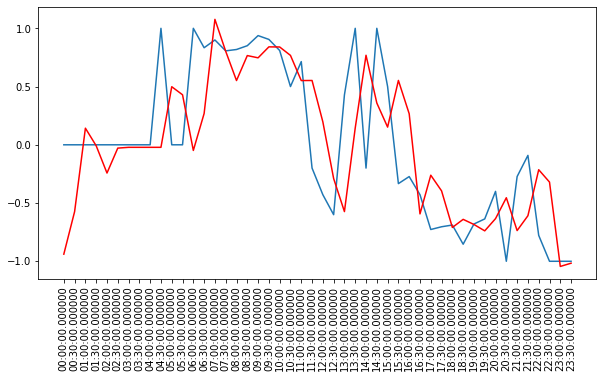

In [33]:


dates = np.arange(0,24,0.5)
xfmt = md.DateFormatter('%H:%M:%S')
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(rotation= 90, )
plt.plot(dts30, test)
plt.plot(dts30, predictions, color='red')
plt.show()